# Quantized Vectors for Classification 

Sergio Alberto De León Martínez 

In [1]:
# tools 
import random
import argparse as arg
from tqdm import tqdm
import os 
import time
import copy

# visualisation
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# data analysis 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pytorch 
import torch 
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchinfo import summary

# set seeds 
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

bold = f"\033[1m"
reset = f"\033[0m"

## Data Exploration 

In [2]:
# load data 
labels          = np.load('labels.npy')
codemaps        = np.load('codemaps.npy')
emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
size_codemap    = codemaps.max()
print('Number of samples: ', len(labels))
print('Shape codemaps:', codemaps.shape)
print('Shape labels:', labels.shape)
print('Size codemap:', size_codemap)
print('Emotion labels:', emotions_labels)

Number of samples:  35000
Shape codemaps: (35000, 12, 12)
Shape labels: (35000, 7)
Size codemap: 255
Emotion labels: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


Como se puede apreciar en la gráfica de abajo, las clases están desbalanceadas. 

/Users/sergio/anaconda3/envs/machine_lr/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


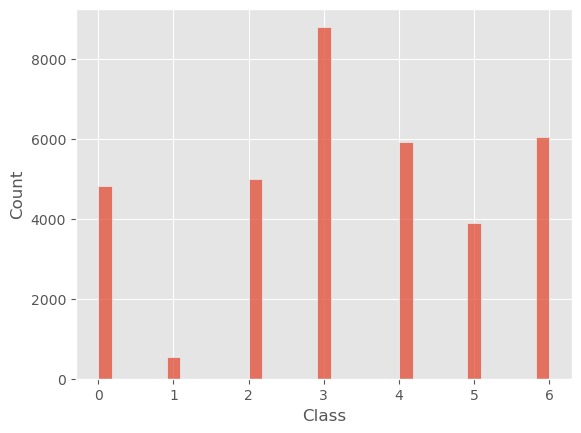

In [125]:
# count per class 
classes = np.array([np.argmax(label) for label in labels])
sns.histplot(classes)
plt.xlabel('Class')
plt.show()

Ahora visualicemos algunos ejemplos por cada clase

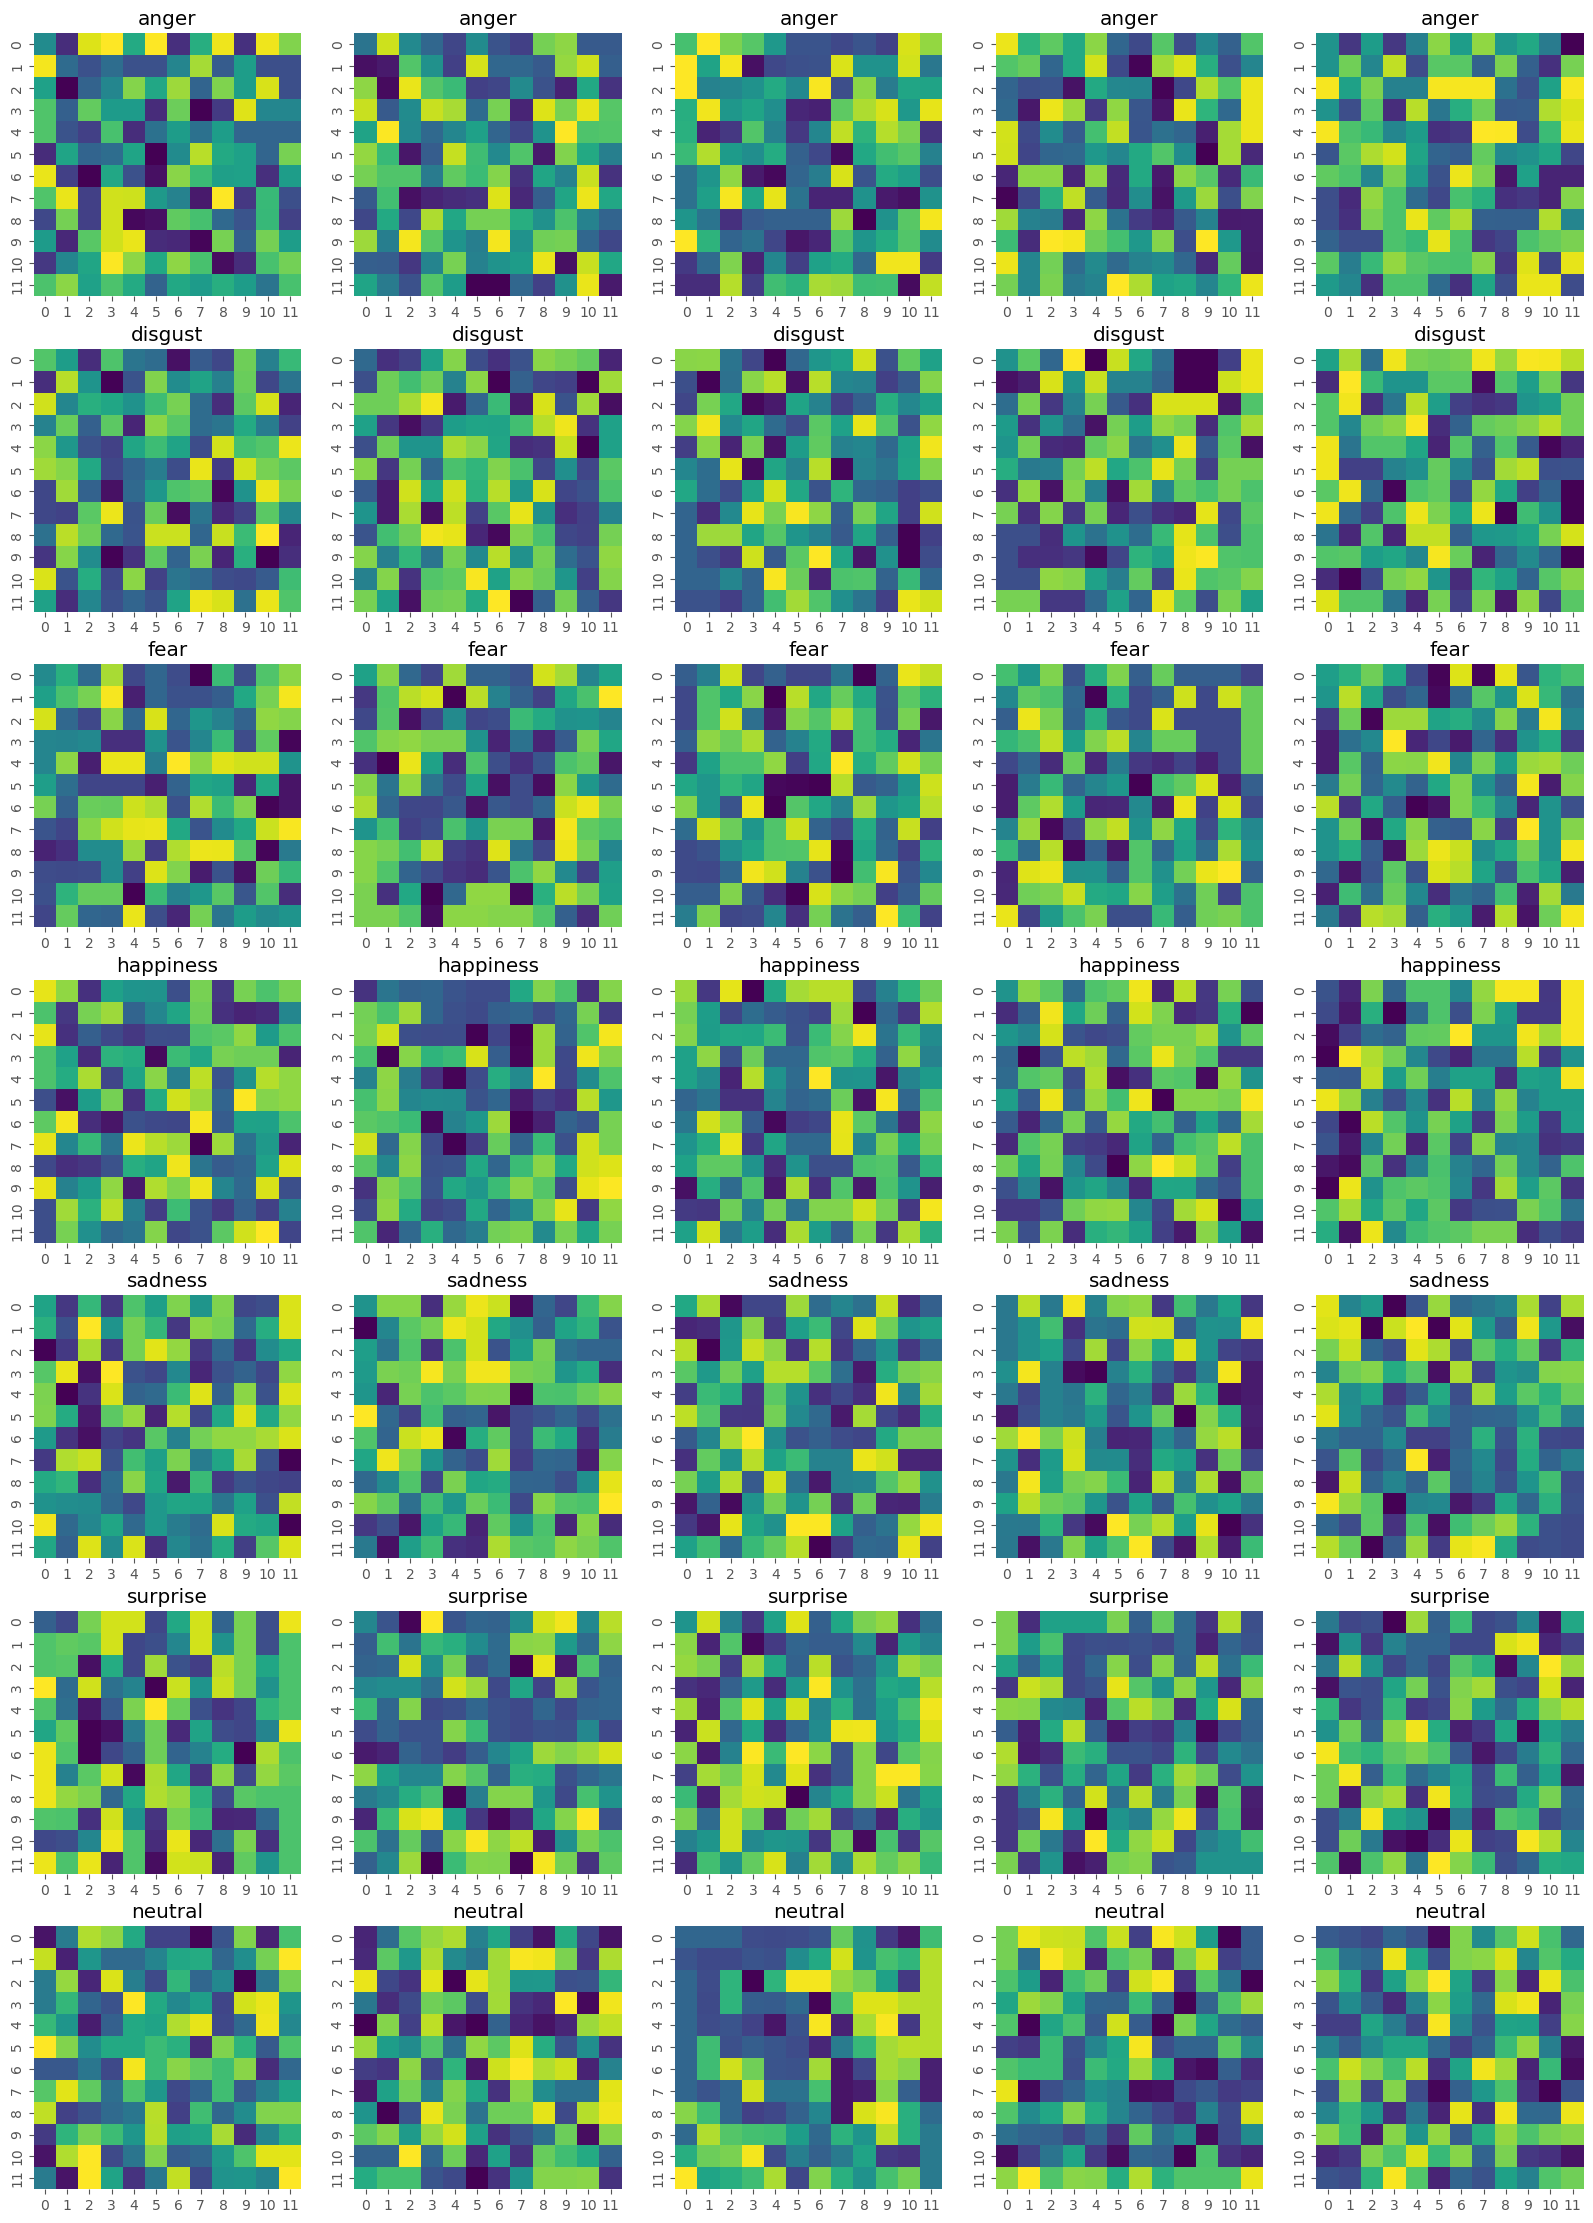

In [126]:
# visualize some examples per class 
df            = pd.DataFrame(codemaps.reshape(-1, 12 * 12))
df['classes'] = classes
num_samples   = 5

# Get the unique classes
unique_classes = sorted(set(classes))

# Create a figure for all subplots
plt.figure(figsize=(20, 4 * len(unique_classes))) 

for j in range(len(unique_classes)):
    # Select samples of current class and reshape them
    curr_class = df[df['classes'] == j].drop('classes', axis=1).to_numpy()
    samples    = curr_class[:num_samples].reshape(-1, 12, 12)

    # Plot the samples
    for i, sample in enumerate(samples):
        plt.subplot(len(unique_classes), num_samples, j * num_samples + i + 1) 
        sns.heatmap(sample, cbar=False, cmap='viridis')
        plt.title(emotions_labels[j])

plt.show()


Antes de clasificar los datos es de interés proyectar los datos a dos dimensiones con PCA para explorar variabilidad en los datos. 

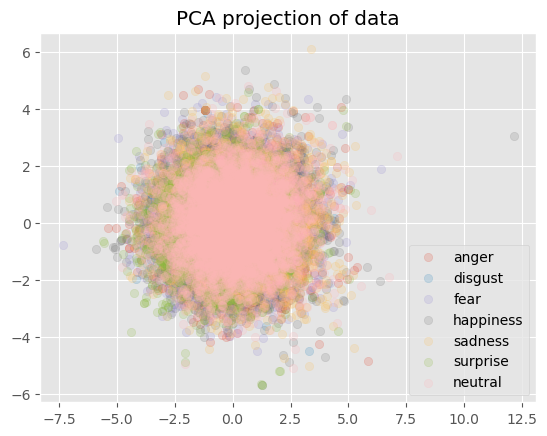

In [127]:
# apply pca to data 
flat_data   = codemaps.reshape(-1, 12 * 12) / size_codemap
scaler      = StandardScaler()
data_scaled = scaler.fit_transform(flat_data) 

pca        = PCA(n_components=2)
data_trans = pca.fit_transform(data_scaled)

# visualize data transformed
for i in range(len(unique_classes)):
    idx = classes == i
    plt.scatter(data_trans[idx, 0], data_trans[idx, 1], label=emotions_labels[i], alpha=0.2)
    plt.legend()

plt.title('PCA projection of data')
plt.show()

## MLP

Ahora preparemos los datos para el modelo de Perceptron Multi-capa.

In [146]:
# ---> preprocess data
# set up 
args = arg
args.batchsize   = 32
args.in_features = 12 * 12
args.epochs      = 30
args.lr_rate     = 3e-4
args.device      = 'cpu'
args.ckpt_dir    = 'vq_classifier_checkpoints'

# convert to tensor 
codemaps_tensor = torch.tensor(codemaps, dtype=torch.float32) / 255
classes         = np.array([np.argmax(label) for label in labels])
labels_tensor   = torch.tensor(classes, dtype=torch.long)

# create dataset & dataloader 
data           = TensorDataset(codemaps_tensor, labels_tensor)
X_train, X_val = random_split(data, [0.9, 0.1])
train_loader   = DataLoader(X_train, args.batchsize, shuffle=True)
val_loader     = DataLoader(X_val, args.batchsize, shuffle=False)

# to handle unbalanced classes 
class_weights = torch.tensor(len(classes) / (np.array([(classes == j).sum() for j in unique_classes])), dtype=torch.float32)

In [129]:
# ---> define the model 
class MLP(nn.Module):
    
    def __init__(self, args):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(args.in_features, 512), 
            nn.ReLU(), 
            nn.Linear(512, 512), 
            nn.ReLU(), 
            nn.Linear(512, 7)
        )

    def forward(self, x):
        return self.mlp(x.view(x.shape[0], -1))  


In [141]:
# ---> define train, validation step 
def train_step(
        args      : arg, 
        model     : nn.Module, 
        optimizer : torch.optim.Optimizer, 
        loader    : torch.utils.data.DataLoader,
        epoch_idx : int, 
        epochs    : int
) -> tuple[float, float]:
        
        model.train()

        step_accuracy = 0
        step_loss     = 0
        n_samples     = 0

        prog_bar = tqdm(loader)
        status   = f'Train:\tEpoch: {epoch_idx}/{epochs}'
        prog_bar.set_description(status)

        for x, label in prog_bar:
                # send to device
                x, label = x.to(args.device), label.to(args.device)

                optimizer.zero_grad()                                   # reset gradients 
                logits = model(x)                                       # pass forward
                loss   = F.cross_entropy(logits, label, 
                                         weight=class_weights)          # compute loss 
                loss.backward()                                         # compute gradient 
                optimizer.step()                                        # update parameters 

                probs          = F.softmax(logits, dim=1)               # compute probabilities 
                pred_idx       = probs.detach().argmax(dim=1)           # compute predicted label 
                n_samples     += x.shape[0]                             # update number of samples 
                step_loss     += loss.item() * x.shape[0]               # update loss 
                step_accuracy += (pred_idx.cpu() == label.cpu()).sum()  # update accuracy 

                step_status  = status + f'\tLoss: {float(step_loss/n_samples):.4f},'
                step_status += f'\tAccuracy: {float(step_accuracy/n_samples):.4f}'
                prog_bar.set_description(step_status)
        
        epoch_loss = float(step_loss / len(loader.dataset))
        epoch_acc  = float(step_accuracy / len(loader.dataset))

        prog_bar.close()

        return epoch_loss, epoch_acc

def val_step(
        args      : arg, 
        model     : nn.Module, 
        loader    : torch.utils.data.DataLoader,
        epoch_idx : int, 
        epochs    : int
) -> tuple[float, float]:
        
        model.eval()

        step_accuracy = 0
        step_loss     = 0
        n_samples     = 0

        prog_bar = tqdm(loader)
        status   = f'Validation:\tEpoch: {epoch_idx}/{epochs}'
        prog_bar.set_description(status)

        for x, label in prog_bar:
                # send to device
                x, label = x.to(args.device), label.to(args.device)

                with torch.no_grad():
                        logits = model(x)                               # pass forward 
                loss = F.cross_entropy(logits, label, 
                                       weight=class_weights)            # compute loss 


                probs          = F.softmax(logits, dim=1)               # compute probabilities 
                pred_idx       = probs.detach().argmax(dim=1)           # compute predicted label 
                n_samples     += x.shape[0]                             # update number of samples 
                step_loss     += loss.item() * x.shape[0]               # update loss 
                step_accuracy += (pred_idx.cpu() == label.cpu()).sum()  # update accuracy 

                step_status  = status + f'\tLoss: {float(step_loss/n_samples):.4f},'
                step_status += f'\tAccuracy: {float(step_accuracy/n_samples):.4f}'
                prog_bar.set_description(step_status)
        
        epoch_loss = float(step_loss / len(loader.dataset))
        epoch_acc  = float(step_accuracy / len(loader.dataset))

        prog_bar.close()

        return epoch_loss, epoch_acc

def main(
        args         : arg, 
        model        : nn.Module, 
        optimizer    : torch.optim.Optimizer,
        train_loader : torch.utils.data.DataLoader,
        val_loader   : torch.utils.data.DataLoader, 
        ckpt_dir     : str
) -> dict:
        
        best_loss = torch.tensor(np.inf)

        epoch_train_loss, epoch_train_acc = [], []
        epoch_val_loss, epoch_val_acc     = [], []

        t_begin = time.time() # time measurement 
        for epoch in range(args.epochs):
                
                train_loss, train_acc = train_step(
                        args, model, optimizer, train_loader, epoch, args.epochs
                )
                
                val_loss, val_acc = val_step(
                        args, model, val_loader, epoch, args.epochs
                )

                train_loss_stat = f"{bold}Train Loss: {train_loss:.4f}{reset}"
                train_acc_stat  = f"{bold}Train Acc: {train_acc:.4f}{reset}"

                val_loss_stat = f"{bold}Val Loss: {val_loss:.4f}{reset}"
                val_acc_stat  = f"{bold}Val Acc: {val_acc:.4f}{reset}"

                print(f"\n{train_loss_stat:<30}{train_acc_stat}")
                print(f"{val_loss_stat:<30}{val_acc_stat}")
        
                epoch_train_loss.append(train_loss)
                epoch_train_acc.append(train_acc)
                epoch_val_loss.append(val_loss)
                epoch_val_acc.append(val_acc)
        
                # save the best model 
                if val_loss < best_loss:
                        best_loss = val_loss
                        print(f"\nModel improved. Saving model...", end="")
                        best_weights = copy.deepcopy(model.state_dict())
                        torch.save(model.state_dict(), os.path.join(ckpt_dir, 'vq_classifier.pth'))
                        print("Done.\n")

                print(f"{'='*72}\n")
        
        print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

        # Load model with the best weights 
        model.load_state_dict(best_weights)
                
        history = dict(
                model      = model, 
                train_acc  = epoch_train_acc, 
                train_loss = epoch_train_loss, 
                val_acc    = epoch_val_acc, 
                val_loss   = epoch_val_loss,
                settings   = args
        )

        return history

def create_checkpoint_dir(checkpoint_dir : str):

        if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)

        print(f'Checkpoint directory: {checkpoint_dir}')
        return checkpoint_dir

def plot_results(     
        metrics,
        title       = None,
        ylabel      = None,
        ylim        = None,
        metric_name = None,
        color       = None,
        args        = None
):


    fig, ax = plt.subplots(figsize=(15, 4))

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx], label=metric_name[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, args.epochs-1])
    plt.ylim(ylim)

    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()


A continuación imprimimos un resumen del modelo. 

In [131]:
ckpt_dir  = create_checkpoint_dir(args.ckpt_dir)
model     = MLP(args)
optimizer = optim.SGD(model.parameters(), lr=args.lr_rate)

print(summary(model, input_size=(1, 12, 12)))

Checkpoint directory: vq_classifier_checkpoints
Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 7]                    --
│    └─Linear: 2-1                       [1, 512]                  74,240
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  262,656
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 7]                    3,591
Total params: 340,487
Trainable params: 340,487
Non-trainable params: 0
Total mult-adds (M): 0.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.36
Estimated Total Size (MB): 1.37


Entrenemos a nuestro modelo. 

In [132]:
history = main(
    args, 
    model, 
    optimizer, 
    train_loader, 
    val_loader, 
    ckpt_dir
)


Train:	Epoch: 0/30	Loss: 1.9461,	Accuracy: 0.2512: 100%|██████████| 985/985 [00:15<00:00, 64.09it/s]
Validation:	Epoch: 0/30	Loss: 1.9443,	Accuracy: 0.2529: 100%|██████████| 110/110 [00:01<00:00, 69.18it/s]



Train Loss: 1.9461    Train Acc: 0.2512
Val Loss: 1.9443      Val Acc: 0.2529

Model improved. Saving model...Done.




Train:	Epoch: 1/30	Loss: 1.9443,	Accuracy: 0.2500: 100%|██████████| 985/985 [00:15<00:00, 63.39it/s]
Validation:	Epoch: 1/30	Loss: 1.9431,	Accuracy: 0.2483: 100%|██████████| 110/110 [00:01<00:00, 77.51it/s]



Train Loss: 1.9443    Train Acc: 0.2500
Val Loss: 1.9431      Val Acc: 0.2483

Model improved. Saving model...Done.




Train:	Epoch: 2/30	Loss: 1.9435,	Accuracy: 0.2451: 100%|██████████| 985/985 [00:19<00:00, 50.35it/s] 
Validation:	Epoch: 2/30	Loss: 1.9426,	Accuracy: 0.2397: 100%|██████████| 110/110 [00:02<00:00, 38.58it/s]



Train Loss: 1.9435    Train Acc: 0.2451
Val Loss: 1.9426      Val Acc: 0.2397

Model improved. Saving model...Done.




Train:	Epoch: 3/30	Loss: 1.9429,	Accuracy: 0.2334: 100%|██████████| 985/985 [00:18<00:00, 54.42it/s]
Validation:	Epoch: 3/30	Loss: 1.9423,	Accuracy: 0.2246: 100%|██████████| 110/110 [00:01<00:00, 86.48it/s]



Train Loss: 1.9429    Train Acc: 0.2334
Val Loss: 1.9423      Val Acc: 0.2246

Model improved. Saving model...Done.




Train:	Epoch: 4/30	Loss: 1.9427,	Accuracy: 0.2183: 100%|██████████| 985/985 [00:15<00:00, 64.42it/s] 
Validation:	Epoch: 4/30	Loss: 1.9422,	Accuracy: 0.2126: 100%|██████████| 110/110 [00:02<00:00, 46.17it/s]



Train Loss: 1.9427    Train Acc: 0.2183
Val Loss: 1.9422      Val Acc: 0.2126

Model improved. Saving model...Done.




Train:	Epoch: 5/30	Loss: 1.9424,	Accuracy: 0.2113: 100%|██████████| 985/985 [00:26<00:00, 36.92it/s]
Validation:	Epoch: 5/30	Loss: 1.9421,	Accuracy: 0.2043: 100%|██████████| 110/110 [00:02<00:00, 48.81it/s]



Train Loss: 1.9424    Train Acc: 0.2113
Val Loss: 1.9421      Val Acc: 0.2043

Model improved. Saving model...Done.




Train:	Epoch: 6/30	Loss: 1.9423,	Accuracy: 0.2042: 100%|██████████| 985/985 [00:22<00:00, 44.43it/s] 
Validation:	Epoch: 6/30	Loss: 1.9420,	Accuracy: 0.1986: 100%|██████████| 110/110 [00:01<00:00, 85.37it/s]



Train Loss: 1.9423    Train Acc: 0.2042
Val Loss: 1.9420      Val Acc: 0.1986

Model improved. Saving model...Done.




Train:	Epoch: 7/30	Loss: 1.9421,	Accuracy: 0.1985: 100%|██████████| 985/985 [00:15<00:00, 62.68it/s]
Validation:	Epoch: 7/30	Loss: 1.9419,	Accuracy: 0.1900: 100%|██████████| 110/110 [00:01<00:00, 70.99it/s]



Train Loss: 1.9421    Train Acc: 0.1985
Val Loss: 1.9419      Val Acc: 0.1900

Model improved. Saving model...Done.




Train:	Epoch: 8/30	Loss: 1.9422,	Accuracy: 0.1950: 100%|██████████| 985/985 [00:12<00:00, 78.54it/s] 
Validation:	Epoch: 8/30	Loss: 1.9419,	Accuracy: 0.1920: 100%|██████████| 110/110 [00:00<00:00, 121.17it/s]



Train Loss: 1.9422    Train Acc: 0.1950
Val Loss: 1.9419      Val Acc: 0.1920

Model improved. Saving model...Done.




Train:	Epoch: 9/30	Loss: 1.9420,	Accuracy: 0.1900: 100%|██████████| 985/985 [00:11<00:00, 87.49it/s] 
Validation:	Epoch: 9/30	Loss: 1.9418,	Accuracy: 0.1911: 100%|██████████| 110/110 [00:00<00:00, 116.65it/s]



Train Loss: 1.9420    Train Acc: 0.1900
Val Loss: 1.9418      Val Acc: 0.1911

Model improved. Saving model...Done.




Train:	Epoch: 10/30	Loss: 1.9420,	Accuracy: 0.1947: 100%|██████████| 985/985 [00:11<00:00, 88.25it/s] 
Validation:	Epoch: 10/30	Loss: 1.9418,	Accuracy: 0.1909: 100%|██████████| 110/110 [00:01<00:00, 81.29it/s]



Train Loss: 1.9420    Train Acc: 0.1947
Val Loss: 1.9418      Val Acc: 0.1909

Model improved. Saving model...Done.




Train:	Epoch: 11/30	Loss: 1.9422,	Accuracy: 0.1908: 100%|██████████| 985/985 [00:10<00:00, 90.19it/s] 
Validation:	Epoch: 11/30	Loss: 1.9417,	Accuracy: 0.1891: 100%|██████████| 110/110 [00:00<00:00, 124.01it/s]



Train Loss: 1.9422    Train Acc: 0.1908
Val Loss: 1.9417      Val Acc: 0.1891

Model improved. Saving model...Done.




Train:	Epoch: 12/30	Loss: 1.9416,	Accuracy: 0.1907: 100%|██████████| 985/985 [00:11<00:00, 83.37it/s] 
Validation:	Epoch: 12/30	Loss: 1.9417,	Accuracy: 0.1914: 100%|██████████| 110/110 [00:00<00:00, 119.04it/s]



Train Loss: 1.9416    Train Acc: 0.1907
Val Loss: 1.9417      Val Acc: 0.1914

Model improved. Saving model...Done.




Train:	Epoch: 13/30	Loss: 1.9415,	Accuracy: 0.1945: 100%|██████████| 985/985 [00:11<00:00, 88.39it/s] 
Validation:	Epoch: 13/30	Loss: 1.9416,	Accuracy: 0.1889: 100%|██████████| 110/110 [00:00<00:00, 122.05it/s]



Train Loss: 1.9415    Train Acc: 0.1945
Val Loss: 1.9416      Val Acc: 0.1889

Model improved. Saving model...Done.




Train:	Epoch: 14/30	Loss: 1.9416,	Accuracy: 0.1920: 100%|██████████| 985/985 [00:13<00:00, 73.52it/s] 
Validation:	Epoch: 14/30	Loss: 1.9416,	Accuracy: 0.1886: 100%|██████████| 110/110 [00:01<00:00, 61.46it/s]



Train Loss: 1.9416    Train Acc: 0.1920
Val Loss: 1.9416      Val Acc: 0.1886

Model improved. Saving model...Done.




Train:	Epoch: 15/30	Loss: 1.9415,	Accuracy: 0.1884: 100%|██████████| 985/985 [00:17<00:00, 55.38it/s] 
Validation:	Epoch: 15/30	Loss: 1.9415,	Accuracy: 0.1886: 100%|██████████| 110/110 [00:00<00:00, 110.73it/s]



Train Loss: 1.9415    Train Acc: 0.1884
Val Loss: 1.9415      Val Acc: 0.1886

Model improved. Saving model...Done.




Train:	Epoch: 16/30	Loss: 1.9412,	Accuracy: 0.1912: 100%|██████████| 985/985 [00:21<00:00, 44.86it/s] 
Validation:	Epoch: 16/30	Loss: 1.9414,	Accuracy: 0.1883: 100%|██████████| 110/110 [00:02<00:00, 49.57it/s]



Train Loss: 1.9412    Train Acc: 0.1912
Val Loss: 1.9414      Val Acc: 0.1883

Model improved. Saving model...Done.




Train:	Epoch: 17/30	Loss: 1.9415,	Accuracy: 0.1926: 100%|██████████| 985/985 [00:21<00:00, 45.42it/s] 
Validation:	Epoch: 17/30	Loss: 1.9414,	Accuracy: 0.1883: 100%|██████████| 110/110 [00:00<00:00, 116.29it/s]



Train Loss: 1.9415    Train Acc: 0.1926
Val Loss: 1.9414      Val Acc: 0.1883

Model improved. Saving model...Done.




Train:	Epoch: 18/30	Loss: 1.9414,	Accuracy: 0.1920: 100%|██████████| 985/985 [00:27<00:00, 35.35it/s]
Validation:	Epoch: 18/30	Loss: 1.9413,	Accuracy: 0.1897: 100%|██████████| 110/110 [00:02<00:00, 38.52it/s]



Train Loss: 1.9414    Train Acc: 0.1920
Val Loss: 1.9413      Val Acc: 0.1897

Model improved. Saving model...Done.




Train:	Epoch: 19/30	Loss: 1.9411,	Accuracy: 0.1921: 100%|██████████| 985/985 [00:17<00:00, 54.83it/s] 
Validation:	Epoch: 19/30	Loss: 1.9413,	Accuracy: 0.1909: 100%|██████████| 110/110 [00:01<00:00, 65.97it/s]



Train Loss: 1.9411    Train Acc: 0.1921
Val Loss: 1.9413      Val Acc: 0.1909

Model improved. Saving model...Done.




Train:	Epoch: 20/30	Loss: 1.9410,	Accuracy: 0.1939: 100%|██████████| 985/985 [00:20<00:00, 47.00it/s] 
Validation:	Epoch: 20/30	Loss: 1.9412,	Accuracy: 0.1886: 100%|██████████| 110/110 [00:00<00:00, 127.94it/s]



Train Loss: 1.9410    Train Acc: 0.1939
Val Loss: 1.9412      Val Acc: 0.1886

Model improved. Saving model...Done.




Train:	Epoch: 21/30	Loss: 1.9407,	Accuracy: 0.1956: 100%|██████████| 985/985 [00:28<00:00, 34.40it/s] 
Validation:	Epoch: 21/30	Loss: 1.9412,	Accuracy: 0.1886: 100%|██████████| 110/110 [00:00<00:00, 120.15it/s]



Train Loss: 1.9407    Train Acc: 0.1956
Val Loss: 1.9412      Val Acc: 0.1886

Model improved. Saving model...Done.




Train:	Epoch: 22/30	Loss: 1.9407,	Accuracy: 0.1940: 100%|██████████| 985/985 [00:16<00:00, 59.68it/s] 
Validation:	Epoch: 22/30	Loss: 1.9412,	Accuracy: 0.1906: 100%|██████████| 110/110 [00:01<00:00, 102.59it/s]



Train Loss: 1.9407    Train Acc: 0.1940
Val Loss: 1.9412      Val Acc: 0.1906

Model improved. Saving model...Done.




Train:	Epoch: 23/30	Loss: 1.9408,	Accuracy: 0.1927: 100%|██████████| 985/985 [00:11<00:00, 84.47it/s] 
Validation:	Epoch: 23/30	Loss: 1.9411,	Accuracy: 0.1903: 100%|██████████| 110/110 [00:00<00:00, 120.74it/s]



Train Loss: 1.9408    Train Acc: 0.1927
Val Loss: 1.9411      Val Acc: 0.1903

Model improved. Saving model...Done.




Train:	Epoch: 24/30	Loss: 1.9408,	Accuracy: 0.1964: 100%|██████████| 985/985 [00:13<00:00, 72.35it/s] 
Validation:	Epoch: 24/30	Loss: 1.9410,	Accuracy: 0.1903: 100%|██████████| 110/110 [00:00<00:00, 122.33it/s]



Train Loss: 1.9408    Train Acc: 0.1964
Val Loss: 1.9410      Val Acc: 0.1903

Model improved. Saving model...Done.




Train:	Epoch: 25/30	Loss: 1.9407,	Accuracy: 0.1957: 100%|██████████| 985/985 [00:10<00:00, 89.58it/s] 
Validation:	Epoch: 25/30	Loss: 1.9410,	Accuracy: 0.1883: 100%|██████████| 110/110 [00:01<00:00, 106.36it/s]



Train Loss: 1.9407    Train Acc: 0.1957
Val Loss: 1.9410      Val Acc: 0.1883

Model improved. Saving model...Done.




Train:	Epoch: 26/30	Loss: 1.9406,	Accuracy: 0.1948: 100%|██████████| 985/985 [00:10<00:00, 90.85it/s] 
Validation:	Epoch: 26/30	Loss: 1.9409,	Accuracy: 0.1869: 100%|██████████| 110/110 [00:00<00:00, 120.42it/s]



Train Loss: 1.9406    Train Acc: 0.1948
Val Loss: 1.9409      Val Acc: 0.1869

Model improved. Saving model...Done.




Train:	Epoch: 27/30	Loss: 1.9407,	Accuracy: 0.1925: 100%|██████████| 985/985 [00:11<00:00, 86.24it/s] 
Validation:	Epoch: 27/30	Loss: 1.9409,	Accuracy: 0.1894: 100%|██████████| 110/110 [00:00<00:00, 123.11it/s]



Train Loss: 1.9407    Train Acc: 0.1925
Val Loss: 1.9409      Val Acc: 0.1894

Model improved. Saving model...Done.




Train:	Epoch: 28/30	Loss: 1.9407,	Accuracy: 0.1915: 100%|██████████| 985/985 [00:11<00:00, 89.54it/s] 
Validation:	Epoch: 28/30	Loss: 1.9408,	Accuracy: 0.1889: 100%|██████████| 110/110 [00:00<00:00, 124.40it/s]



Train Loss: 1.9407    Train Acc: 0.1915
Val Loss: 1.9408      Val Acc: 0.1889

Model improved. Saving model...Done.




Train:	Epoch: 29/30	Loss: 1.9403,	Accuracy: 0.1944: 100%|██████████| 985/985 [00:15<00:00, 64.92it/s] 
Validation:	Epoch: 29/30	Loss: 1.9408,	Accuracy: 0.1880: 100%|██████████| 110/110 [00:01<00:00, 84.48it/s]



Train Loss: 1.9403    Train Acc: 0.1944
Val Loss: 1.9408      Val Acc: 0.1880

Model improved. Saving model...Done.


Total time: 530.84s, Best Loss: 1.941


Finalmente visualicemos los resultados, evaluemos el rendimiento final y hagmos predicciones sobre el dataset de evaluación. 

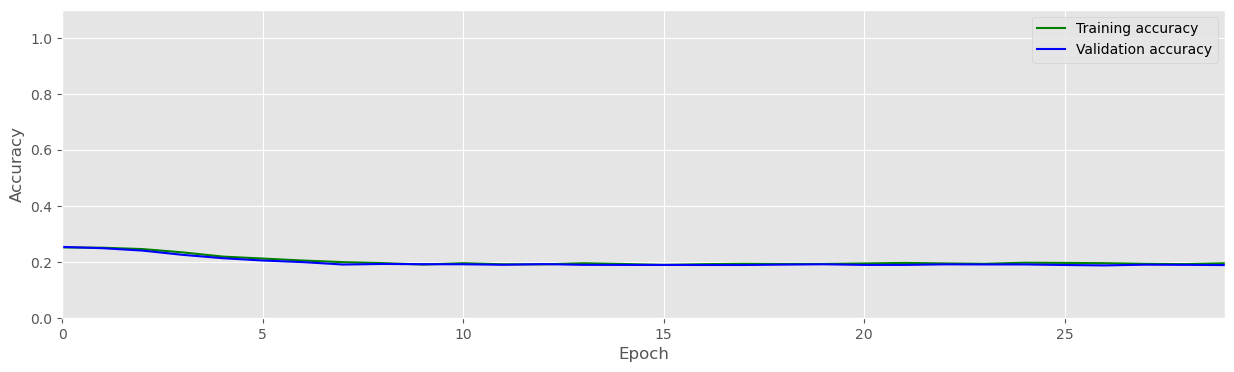

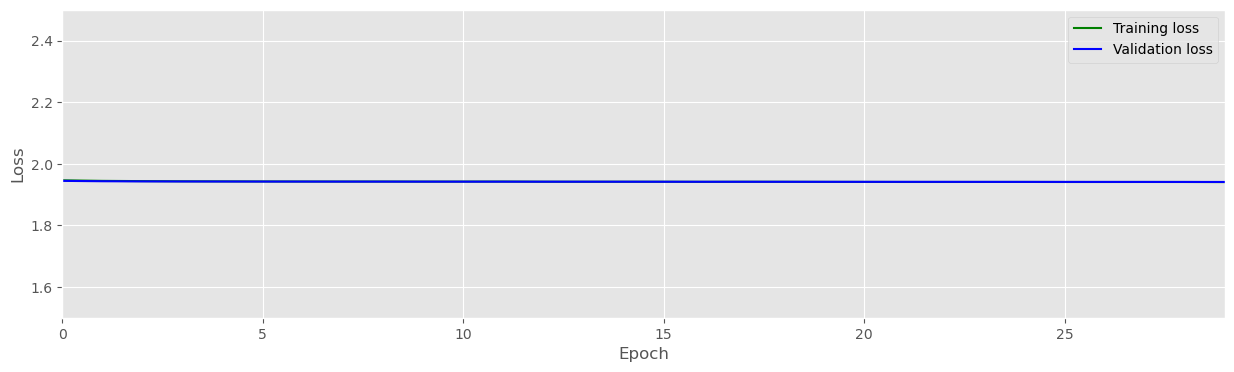

In [144]:
# visualise results 
train_loss = history['train_loss']
train_acc  = history['train_acc']
val_loss   = history['val_loss']
val_acc    = history['val_acc']
settings   = history['settings']

plot_results(
    metrics=[train_acc, val_acc], 
    ylabel='Accuracy', 
    ylim=[0, 1.1], 
    metric_name=['Training accuracy', 'Validation accuracy'], 
    color=['g', 'b'], 
    args=settings
)

plot_results(
    metrics=[train_loss, val_loss], 
    ylabel='Loss', 
    ylim=[1.5, 2.5], 
    metric_name=['Training loss', 'Validation loss'], 
    color=['g', 'b'], 
    args=settings
)

Evaluation in test data with best model


Validation:	Epoch: 1/1	Loss: 1.9442,	Accuracy: 0.1886: 100%|██████████| 110/110 [00:01<00:00, 63.49it/s]


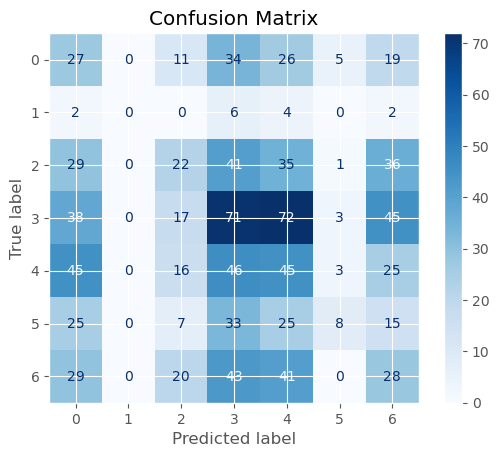

In [172]:
# evaluation and prediction 
def predict_batch( 
        model    : nn.Module, 
        batch_in : torch.tensor, 
):
        model.eval()

        with torch.no_grad():
            batch_logits = model(batch_in)
            
        batch_preds = batch_logits.argmax(dim=1)

        return batch_preds.cpu()
       
best_model = history['model']
print("Evaluation in test data with best model")
eval_loss, eval_acc = val_step(args, best_model, val_loader, 1, 1)

# select a batch for prediction 
size_batch  = 1000
shuffle_idx = random.sample(range(len(val_loader.dataset)), size_batch)
batch_data, batch_labels = val_loader.dataset[shuffle_idx]

# predict and compute cm 
preds = predict_batch(best_model, batch_data)
cm    = confusion_matrix(batch_labels.numpy(), preds.numpy())

# Display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Extreme Learning Machine 

Ahora implemenetemos una máquina de aprendizaje extremo que pueda considerar regresión de tipo Ridge, Lasso y ElasticNet.

In [9]:
# ---> Extreme learning machine 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet

class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_size, output_size, regularization=None):
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.regularization       = regularization 
        self.regularization_param = 1.0
        self.l1_ratio             = 0.5

        # random initialization of the weights of the hidden layer 
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_size))
        self.biases = np.random.uniform(-1, 1, (self.hidden_size,))
        
        # output weights are computed later 
        self.output_weights = None
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def train(self, X_train, y_train):
        # compute the output of the hidden layer 
        H = self.sigmoid(np.dot(X_train, self.input_weights) + self.biases)

        if self.regularization == 'ridge':
            
            I     = np.eye(self.hidden_size)  
            H_T_H = np.dot(H.T, H)
            regularized_term = self.regularization_param * I
            
            # compute the weights of the hidden layer using the regularized solution 
            self.output_weights = np.dot(np.linalg.inv(H_T_H + regularized_term), np.dot(H.T, y_train))

        elif self.regularization == 'lasso':

            # use lasso regularization L1 
            lasso = Lasso(alpha=self.regularization_param, fit_intercept=False, max_iter=10000)
            self.output_weights = np.array([lasso.fit(H, y_train[:, i]).coef_ for i in range(y_train.shape[1])]).T
        
        elif self.regularization == 'elastic-net':

             # Utilizar ElasticNet para ajustar los pesos de la capa de salida con regularización L1 y L2
            elastic_net = ElasticNet(alpha=self.regularization_param, l1_ratio=self.l1_ratio, fit_intercept=False, max_iter=10000)
            self.output_weights = np.array([elastic_net.fit(H, y_train[:, i]).coef_ for i in range(y_train.shape[1])]).T
    
    
        elif self.regularization == None:
        
            # compute the weights of the hidden layer 
            H_pseudo_inverse = np.linalg.pinv(H)  # Moore-Penrose psudoinverse 
            self.output_weights = np.dot(H_pseudo_inverse, y_train)
    
    def predict(self, X):
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)



In [4]:
# split data 
data = codemaps.reshape(-1, 12 * 12) / 255
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# train elm 
hidden_neurons = 5000
elm = ExtremeLearningMachine(12 * 12, hidden_neurons, 7)
elm.train(X_train, y_train)

# predict 
train_preds_elm = elm.predict(X_train)

In [187]:
# predict
train_pred_cls = train_preds_elm.argmax(axis=1)
val_preds_elm  = elm.predict(X_val)
val_preds_cls  = val_preds_elm.argmax(axis=1)

# accuracy 
train_acc = (train_pred_cls == y_train.argmax(axis=1)).sum() / len(y_train)
val_acc   = (val_preds_cls == y_val.argmax(axis=1)).sum() / len(y_val)

print("Train accuracy: ", train_acc) 
print("Validation accuracy: ", val_acc)

/var/folders/7w/zntwcp0508sfxktwdh3h5x4h0000gn/T/ipykernel_32225/1553005090.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train accuracy:  0.5200714285714285
Validation accuracy:  0.22342857142857142


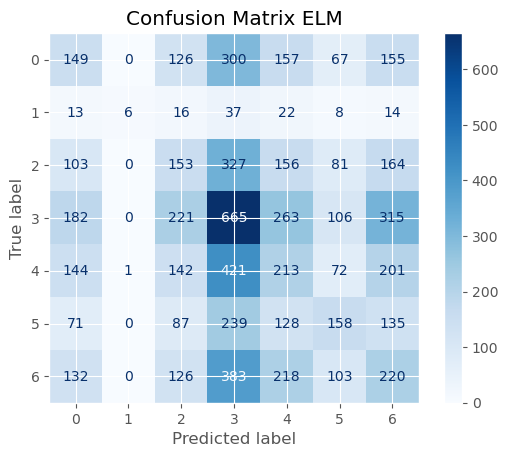

In [189]:
cm_val = confusion_matrix(y_val.argmax(axis=1), val_preds_cls)
# Display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ELM')
plt.show()

In [9]:
# ---> use ridge regularization 
hidden_neurons = 5000
elm_ridge = ExtremeLearningMachine(12 * 12, hidden_neurons, 7, 'ridge')
elm_ridge.train(X_train, y_train)

/var/folders/7w/zntwcp0508sfxktwdh3h5x4h0000gn/T/ipykernel_43842/75741899.py:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [10]:
# predict 
train_preds_elm = elm_ridge.predict(X_train)        # train 
train_pred_cls  = train_preds_elm.argmax(axis=1)    # train 
val_preds_elm   = elm_ridge.predict(X_val)          # val
val_preds_cls   = val_preds_elm.argmax(axis=1)      # val 

# accuracy 
train_acc = (train_pred_cls == y_train.argmax(axis=1)).sum() / len(y_train)
val_acc   = (val_preds_cls == y_val.argmax(axis=1)).sum() / len(y_val)

print("Train accuracy: ", train_acc) 
print("Validation accuracy: ", val_acc)

/var/folders/7w/zntwcp0508sfxktwdh3h5x4h0000gn/T/ipykernel_43842/75741899.py:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Train accuracy:  0.5160714285714286
Validation accuracy:  0.21842857142857142


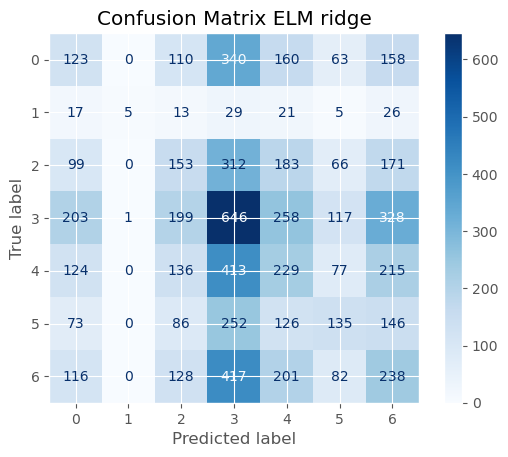

In [12]:
cm_val = confusion_matrix(y_val.argmax(axis=1), val_preds_cls)
# Display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ELM ridge')
plt.show()

In [5]:
# ---> use lasso regularization 
hidden_neurons = 1000
elm_lasso      = ExtremeLearningMachine(12 * 12, hidden_neurons, 7, 'lasso')
elm_lasso.regularization_param = 0.01
elm_lasso.train(X_train, y_train)

In [6]:
# predict 
train_preds_elm = elm_lasso.predict(X_train)        # train 
train_pred_cls  = train_preds_elm.argmax(axis=1)    # train 
val_preds_elm   = elm_lasso.predict(X_val)          # val
val_preds_cls   = val_preds_elm.argmax(axis=1)      # val 

# accuracy 
train_acc = (train_pred_cls == y_train.argmax(axis=1)).sum() / len(y_train)
val_acc   = (val_preds_cls == y_val.argmax(axis=1)).sum() / len(y_val)

print("Train accuracy: ", train_acc) 
print("Validation accuracy: ", val_acc)

Train accuracy:  0.2517142857142857
Validation accuracy:  0.25014285714285717


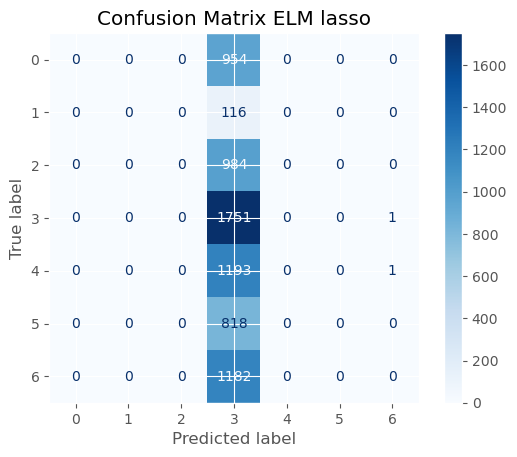

In [8]:
cm_val = confusion_matrix(y_val.argmax(axis=1), val_preds_cls)
# Display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ELM lasso')
plt.show()

In [10]:
# ---> use ElasticNet regularization 
hidden_neurons  = 1000
elm_elastic_net = ExtremeLearningMachine(12 * 12, hidden_neurons, 7, 'elastic-net')
elm_elastic_net.regularization_param = 0.01
elm_elastic_net.train(X_train, y_train)

In [11]:
# predict 
train_preds_elm = elm_elastic_net.predict(X_train)        # train 
train_pred_cls  = train_preds_elm.argmax(axis=1)          # train 
val_preds_elm   = elm_elastic_net.predict(X_val)          # val
val_preds_cls   = val_preds_elm.argmax(axis=1)            # val 

# accuracy 
train_acc = (train_pred_cls == y_train.argmax(axis=1)).sum() / len(y_train)
val_acc   = (val_preds_cls == y_val.argmax(axis=1)).sum() / len(y_val)

print("Train accuracy: ", train_acc) 
print("Validation accuracy: ", val_acc)

Train accuracy:  0.2517142857142857
Validation accuracy:  0.2502857142857143


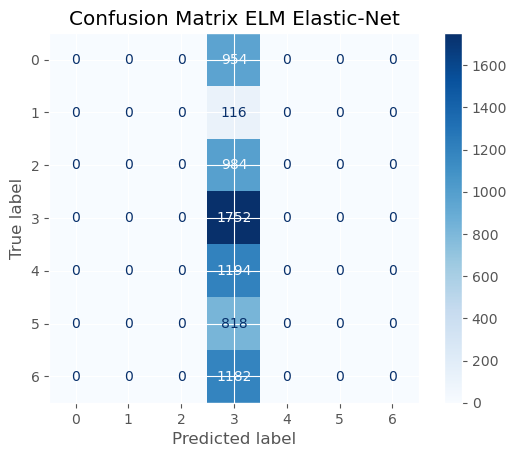

In [12]:
cm_val = confusion_matrix(y_val.argmax(axis=1), val_preds_cls)
# Display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ELM Elastic-Net')
plt.show()